# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Understanding the data

In [3]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

## DATA EXPLORATION

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
portfolio.head()


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [7]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [8]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [9]:
#Dissecting the column 'channels' for better utimization of it 

channels_div = set()
for i in portfolio.channels:
    channels_div.update(set(i))
channels_div

{'email', 'mobile', 'social', 'web'}

In [10]:
# split the channel into different attribute
for i in channels_div:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,web,social,mobile,email
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [11]:
# dropping the 'channels' column, resulting in a cleaner dataframe
portfolio = portfolio.drop('channels', axis=1)
portfolio

,difficulty,duration,id,offer_type,reward,web,social,mobile,email
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,0,1,1


In [12]:
#profile dataframe

profile

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [14]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [15]:
#finding null values

profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [16]:
#replacing null values

profile['gender'].fillna('NA', inplace=True)
profile['income'].fillna((profile['income'].mean()), inplace=True)

In [17]:
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [18]:
# find different keys in value column

keys = []
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)

keys


['offer id', 'amount', 'offer_id', 'reward']

In [19]:
# Iterate over transcript table, check value column and update it, put each key in seperated column.

transcript['offer_id'] = ''
transcript['amount'] = 0
transcript['reward'] = 0

for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id':
            transcript.at[idx, 'offer_id']= row['value'][k]
        if k == 'amount':
            transcript.at[idx, 'amount']= row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'reward']= row['value'][k]

In [20]:
transcript = transcript.drop('value', axis=1)
transcript.head()

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [21]:
profile['income'].mean() #finding mean income of customers

65404.991568296799

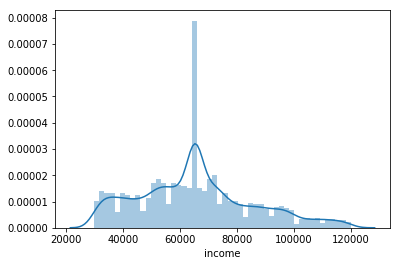

In [23]:
import seaborn as sns
sns.distplot(profile['income'], bins=50, hist_kws={'alpha': 0.4});


In [24]:
profile['age'].mean() #finding average age of customers


62.531411764705879

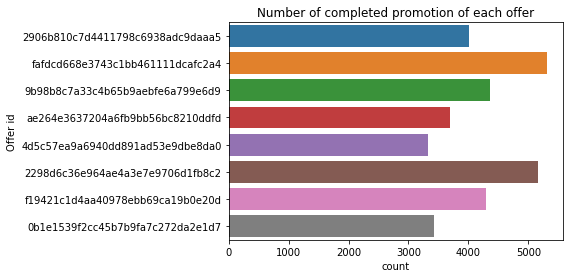

In [25]:
# We we check the completed orders only

import matplotlib.pyplot as plt
import seaborn as sns
completed_off_count = transcript[transcript['event'] == 'offer completed']

sns.countplot(y=completed_off_count['offer_id'])
plt.title('Number of completed promotion of each offer')
plt.ylabel('Offer id')
plt.show()

In [26]:
def get_offer_type(offer_id):
    try:
        offer_type = portfolio[portfolio['id'] == offer_id]['offer_type'].values[0]
        return offer_type
    except:
        offer_type = 'NA'
        return offer_type

transcript['offer_type'] = transcript.apply(lambda x: get_offer_type(x['offer_id']), axis=1)

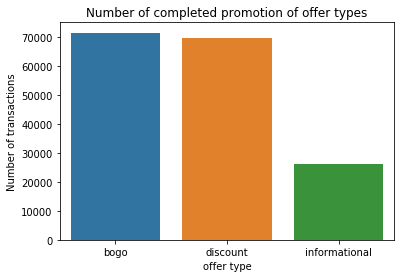

In [27]:
sns.countplot(transcript[transcript['offer_type'] != 'NA']['offer_type'])
plt.title('Number of completed promotion of offer types')
plt.ylabel('Number of transactions')
plt.xlabel('offer type')
plt.show()

From the above graph we dervice that BOGO and discount are the most used

In [28]:
profile['age_groups'] = pd.cut(profile.age, bins=[0, 12, 18, 21, 64, 200], 
                               labels=['children', 'teenager', 'Young adult', 'Adult', 'Old'])

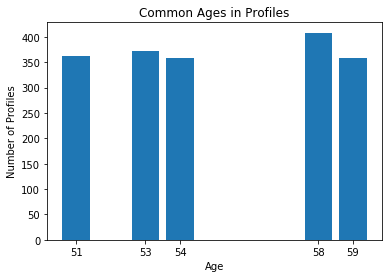

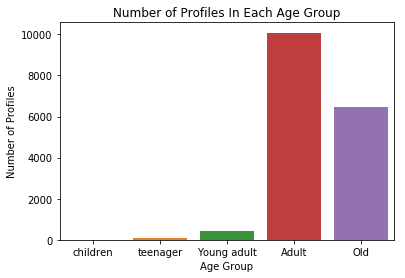

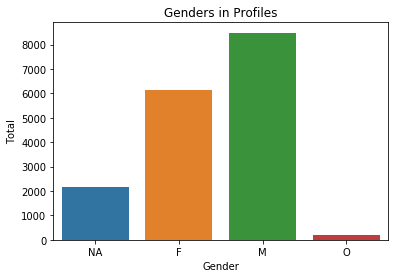

In [29]:
# 118 is an outlier, so it is not included
top5_ages = profile['age'].value_counts()[1:].head(5).reset_index()
plt.bar(top5_ages['index'], top5_ages['age'])
plt.title('Common Ages in Profiles')
plt.ylabel('Number of Profiles')
plt.xlabel('Age')
plt.xticks(top5_ages['index'], rotation = 0)
plt.show()

sns.countplot(x='age_groups', data=profile)
plt.title('Number of Profiles In Each Age Group')
plt.ylabel('Number of Profiles')
plt.xlabel('Age Group')
plt.show()

sns.countplot(profile['gender'])
plt.title('Genders in Profiles')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show()

It can be observed that customers who are adult and male are most prone to make a traction in Starbucks.

In [30]:
loyal_customer_count = transcript[(transcript['event'] == 'offer completed') | (transcript['event'] == 'transaction')].groupby(['person', 'event'])['amount'].sum().reset_index()
loyal_customer_count = loyal_customer_count.sort_values('amount', ascending=False).head(10)

for idx, row in loyal_customer_count.iterrows():
    print(f'Profile ID: {row["person"]}')
    print(f'Number of Completed Offers:{completed_off_count[(completed_off_count["person"] == row["person"]) & (completed_off_count["event"] == "offer completed")].shape[0]}')
    print(f'Amount:${row["amount"]}')
    

Profile ID: 3c8d541112a74af99e88abbd0692f00e
Number of Completed Offers:5
Amount:$1606
Profile ID: f1d65ae63f174b8f80fa063adcaa63b7
Number of Completed Offers:6
Amount:$1360
Profile ID: ae6f43089b674728a50b8727252d3305
Number of Completed Offers:3
Amount:$1320
Profile ID: 626df8678e2a4953b9098246418c9cfa
Number of Completed Offers:4
Amount:$1314
Profile ID: 73afdeca19e349b98f09e928644610f8
Number of Completed Offers:5
Amount:$1314
Profile ID: 52959f19113e4241a8cb3bef486c6412
Number of Completed Offers:5
Amount:$1285
Profile ID: ad1f0a409ae642bc9a43f31f56c130fc
Number of Completed Offers:3
Amount:$1256
Profile ID: d240308de0ee4cf8bb6072816268582b
Number of Completed Offers:5
Amount:$1244
Profile ID: 946fc0d3ecc4492aa4cc06cf6b1492c3
Number of Completed Offers:4
Amount:$1224
Profile ID: 6406abad8e2c4b8584e4f68003de148d
Number of Completed Offers:3
Amount:$1206


From the above output we get the most loyal customers with most transactions

In [31]:
#To obtain agegroups from profile dataframe
def get_customer_age_group(profile_id):
    age_group = profile[profile['id'] == profile_id]['age_groups'].values[0]
    return age_group

transcript['age_group'] = transcript.apply(lambda x: get_customer_age_group(x['person']), axis=1)


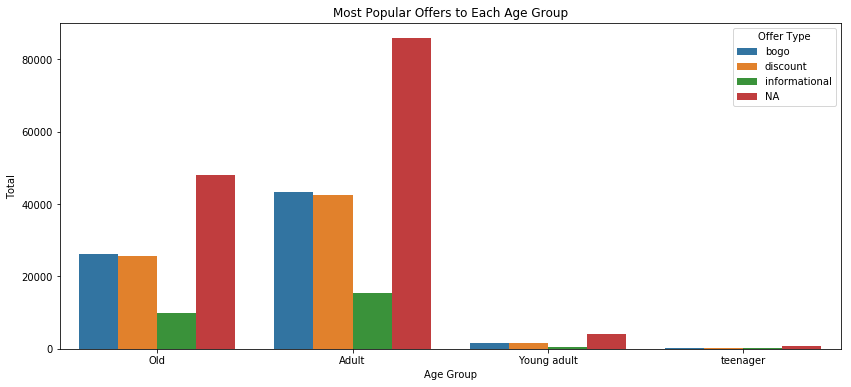

In [32]:
#To understand how the promotions were used by various age groups
plt.figure(figsize=(14, 6))
sns.countplot(x="age_group", hue="offer_type", data=transcript)
plt.title('Most Popular Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.legend(title='Offer Type')
plt.show()

Since the last visualization includes NA values that inhibits our understanding of the age groups, we do the below: we ignore the NA values to get better visualization in terms of income

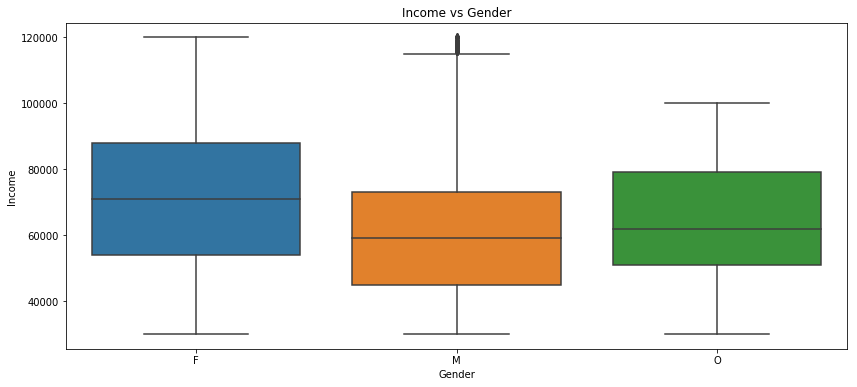

In [33]:
plt.figure(figsize=(14, 6))
sns.boxplot(x=profile[profile['gender'] != 'NA']['gender'], y=profile['income'])
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.show()

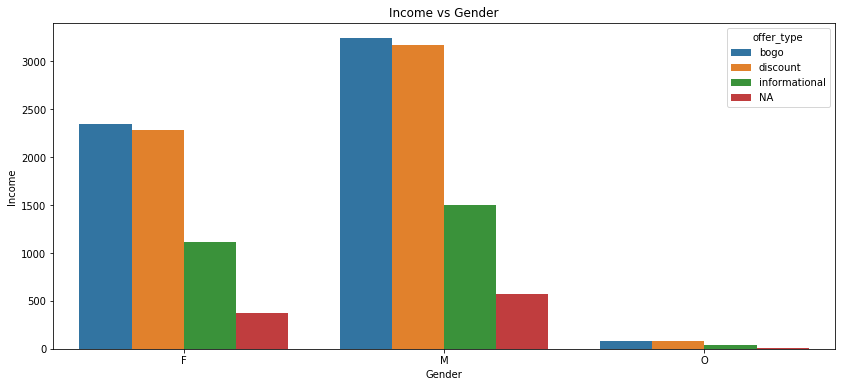

In [34]:
# to understand better

plt.figure(figsize=(14, 6))
sns.countplot(x=profile[profile['gender'] != 'NA']['gender'], hue = 'offer_type', data=transcript)
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.show()

It is clear that male and female genders prefer BOGO over discount even if there is only a small difference

## Model the data

In [35]:
#To guess the offer_type, we use transcript dataframe's offer id column.
transcript = transcript[transcript['offer_id'] != 'NA']

Here I add gender and income to transcript so all the data is we need is in one place

In [39]:
def get_customer_gender(profile_id):
    gender = profile[profile['id'] == profile_id]['gender'].values[0]
    return gender

transcript['gender'] = transcript.apply(lambda x: get_customer_gender(x['person']), axis=1)

In [40]:
def get_customer_income(profile_id):
    income = profile[profile['id'] == profile_id]['income'].values[0]
    return income

transcript['income'] = transcript.apply(lambda x: get_customer_income(x['person']), axis=1)

In [41]:
transcript.head()


,event,person,time,offer_id,amount,reward,offer_type,age_group,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,bogo,Old,F,100000.000000
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount,Old,NA,65404.991568
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,discount,Old,M,70000.000000
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,discount,Old,NA,65404.991568
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,bogo,Old,NA,65404.991568


Splitting the dataframe to obtain target and features

In [42]:
# To get features

labels_event = transcript['event'].astype('category').cat.categories.tolist()
replace_map_comp_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}
print(replace_map_comp_event)

labels_offer_id = transcript['offer_id'].astype('category').cat.categories.tolist()
replace_map_comp_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}
print(replace_map_comp_offer_id)

labels_age_group = transcript['age_group'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}
print(replace_map_comp_age_group)

labels_gender = transcript['gender'].astype('category').cat.categories.tolist()
replace_map_comp_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
print(replace_map_comp_gender)

{'event': {'offer completed': 1, 'offer received': 2, 'offer viewed': 3, 'transaction': 4}}
{'offer_id': {'': 1, '0b1e1539f2cc45b7b9fa7c272da2e1d7': 2, '2298d6c36e964ae4a3e7e9706d1fb8c2': 3, '2906b810c7d4411798c6938adc9daaa5': 4, '3f207df678b143eea3cee63160fa8bed': 5, '4d5c57ea9a6940dd891ad53e9dbe8da0': 6, '5a8bc65990b245e5a138643cd4eb9837': 7, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 8, 'ae264e3637204a6fb9bb56bc8210ddfd': 9, 'f19421c1d4aa40978ebb69ca19b0e20d': 10, 'fafdcd668e3743c1bb461111dcafc2a4': 11}}
{'age_group': {'Adult': 1, 'Old': 2, 'Young adult': 3, 'teenager': 4}}
{'gender': {'F': 1, 'M': 2, 'NA': 3, 'O': 4}}


In [43]:
#Target:

labels_offer_type = transcript['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}
print(replace_map_comp_offer_type)

{'offer_type': {'NA': 1, 'bogo': 2, 'discount': 3, 'informational': 4}}


In [44]:
# To replace categorical with numerical
transcript.replace(replace_map_comp_event, inplace=True)
transcript.replace(replace_map_comp_offer_id, inplace=True)
transcript.replace(replace_map_comp_age_group, inplace=True)
transcript.replace(replace_map_comp_gender, inplace=True)
transcript.replace(replace_map_comp_offer_type, inplace=True)

In [45]:
transcript.head()

,event,person,time,offer_id,amount,reward,offer_type,age_group,gender,income
0,2,78afa995795e4d85b5d9ceeca43f5fef,0,8,0,0,2,2,1,100000.000000
1,2,a03223e636434f42ac4c3df47e8bac43,0,2,0,0,3,2,3,65404.991568
2,2,e2127556f4f64592b11af22de27a7932,0,4,0,0,3,2,2,70000.000000
3,2,8ec6ce2a7e7949b1bf142def7d0e0586,0,11,0,0,3,2,3,65404.991568
4,2,68617ca6246f4fbc85e91a2a49552598,0,6,0,0,2,2,3,65404.991568


In [46]:
# To split the data into features and target label

target = transcript['offer_type']
features = transcript.drop(['person', 'offer_type'], axis = 1)

In [47]:
target.head()


0    2
1    3
2    3
3    3
4    2
Name: offer_type, dtype: int64

In [48]:
features.head()


,event,time,offer_id,amount,reward,age_group,gender,income
0,2,0,8,0,0,2,1,100000.000000
1,2,0,2,0,0,2,3,65404.991568
2,2,0,4,0,0,2,2,70000.000000
3,2,0,11,0,0,2,3,65404.991568
4,2,0,6,0,0,2,3,65404.991568


## Normalisation step

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
to_normalize = ['time', 'amount', 'reward', 'income']

features[to_normalize] = scaler.fit_transform(features[to_normalize])
features.head()

,event,time,offer_id,amount,reward,age_group,gender,income
0,2,0.0,8,0.0,0.0,2,1,0.777778
1,2,0.0,2,0.0,0.0,2,3,0.393389
2,2,0.0,4,0.0,0.0,2,2,0.444444
3,2,0.0,11,0.0,0.0,2,3,0.393389
4,2,0.0,6,0.0,0.0,2,3,0.393389


To create train and test sets

In [50]:
from sklearn.model_selection import train_test_split, GridSearchCV


In [51]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)


In [52]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (229900, 8)
Training Labels Shape: (229900,)
Testing Features Shape: (76634, 8)
Testing Labels Shape: (76634,)


In [53]:
# In this project I am taking accuracy. 

def pred_score(model):
    pred = model.predict(X_test)
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    # Calculate mean absolute percentage error
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    return round(accuracy, 2)

## K-Nearest Neighbors

In [54]:
#K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
print(f'Accuracy of K-NN classifier on training set: {round(knn.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(knn)}%')

Accuracy of K-NN classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


## Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)
print(f'Accuracy of Logistic regression classifier on training set: {round(logreg.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(logreg)}%')

Accuracy of Logistic regression classifier on training set: 80.52%.
Prediction Accuracy: 92.8%


## Decision Tree

In [56]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(dt)}%')

Accuracy of Decision Tree classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


## Support Vector Model

In [57]:
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(svm.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(svm)}%')


Accuracy of SVM classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


In [58]:
# results
models = [logreg, knn, dt, svm]
model_names = [type(n).__name__ for n in models]
tr_accuracy = [x.score(X_train, y_train)*100 for x in models]
pred_accuracy = [pred_score(y) for y in models]

In [59]:
results = [tr_accuracy, pred_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accuracy']) 
results_df

,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,SVC
Training Accuracy,80.522836,100.0,100.0,100.0
Predicting Accuracy,92.800000,100.0,100.0,100.0


Eventhough it can be observed that we obtained 100 percent accuracy on Decision tree and SCV training and test 
datasets, we will choose logistic regression as it means our model will not suffer overfitting. Also, in this scenario
with the datasets we are using binomial outcomes must be favoured.


Finally, to conclude, in this project, I tried to analyze and make model to predict the best offer to give a 
Starbucks customer. First I explored the data and see what I have to change before starting the analysis.
Then I did some exploratory analysis on the data after cleaning. In conclusion, the company should 
give more offers to males than females since they have more completed offers. And they should focus 
more on BOGO and Discount offers since they are the one that tend to make customers buy more.

Imporvement: To improve the model, since we have great accuracy- using other models doesnt make sense. But personally, I'd like to learn more programming to understand and obtain deeper and more insights from the given dataset.